In [1]:
import pandas as pd 

# Thư viện bắt buộc
from pandas_datareader.data import DataReader

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
# Read the CSV file and set 'Date' as the index
df = pd.read_csv('AAPL.csv')
df.set_index('Date', inplace=True)

# Convert the 'Date' index to datetime format
df.index = pd.to_datetime(df.index, dayfirst=True)

# Filter the DataFrame 
start_date = '2005/05/27'
end_date = '2023/05/24'
mask = (df.index >= start_date) & (df.index <= end_date)
df_filtered = df.loc[mask]
df_filtered

C:\Users\DELL\AppData\Local\Temp\ipykernel_1544\2093700134.py:6: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index, dayfirst=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-05-27,1.451429,1.456786,1.428929,1.448571,1.224698,316008000
2005-05-31,1.452143,1.455000,1.413571,1.420000,1.200543,404205200
2005-06-01,1.424643,1.455714,1.423571,1.439286,1.216848,453812800
2005-06-02,1.430357,1.440000,1.414286,1.430000,1.208997,373973600
2005-06-03,1.362857,1.377857,1.348929,1.365714,1.154647,956869200
...,...,...,...,...,...,...
2023-05-18,173.000000,175.240005,172.580002,175.050003,174.125259,65496700
2023-05-19,176.389999,176.389999,174.940002,175.160004,174.234695,55772400
2023-05-22,173.979996,174.710007,173.449997,174.199997,173.279739,43570900


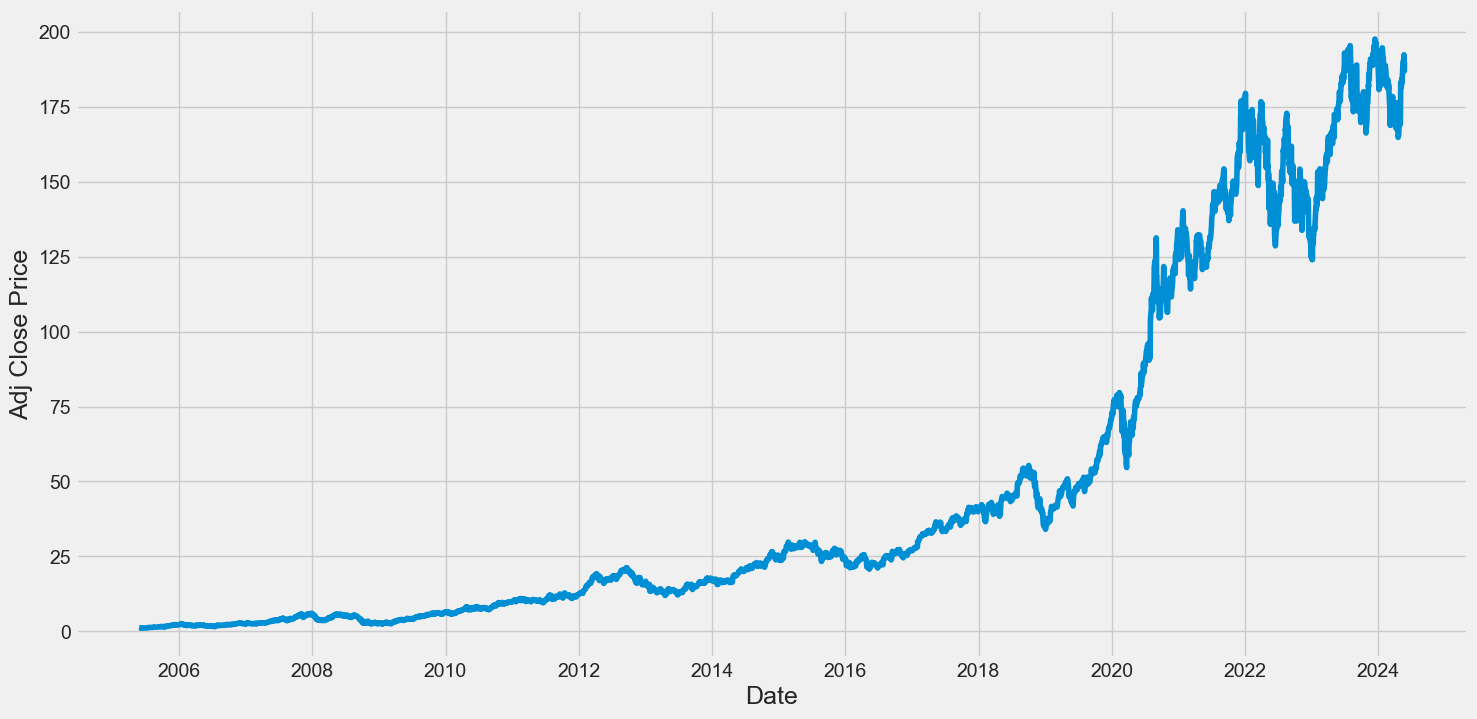

In [3]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.show()

In [4]:
def splitDataset(df):
    length = df.shape[0]
    train_df = df[:length - 30]
    test_df = df[length - 30:]
    return train_df, test_df

train_df, test_df = splitDataset(df)

train_df.shape, test_df.shape

((4751, 6), (30, 6))

In [5]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Adj Close'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(4751, 1)

In [6]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(4751,)

In [7]:
# tạo dữ liệu train_X và train_y
def createTrainX_y(scaled_train_data, time_steps=1500, out_length=30):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y(scaled_train_data)
train_X.shape, train_y.shape

((3222, 1500, 1), (3222, 30))

In [8]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y)),
])

train_X, train_y = preprocess_pipeline.fit_transform(train_df)
train_X.shape, train_y.shape

((3222, 1500, 1), (3222, 30))

In [9]:
# Tạo model 
def createModel(train_X, time_steps=1500, out_length=30):
    model = Sequential()
    model.add(LSTM(500, activation='tanh', return_sequences=False, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return modelT

In [10]:
# build model 
model = createModel(train_X)
model.summary()
model.fit(train_X, train_y, batch_size=1, epochs=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1004000   
                                                                 
 dense (Dense)               (None, 30)                15030     
                                                                 
Total params: 1019030 (3.89 MB)
Trainable params: 1019030 (3.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
3222/3222 [==============================] - 16977s 5s/step - loss: 0.0030


In [11]:
# tạo tập test_inputs
test_inputs = df[len(df) - len(test_df) - 1500 :]
test_X, test_y = preprocess_pipeline.transform(test_inputs)
test_X.shape, test_y.shape

((1, 1500, 1), (1, 30))

In [12]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = scaler.inverse_transform(pred_test)
print(pred_test[0])
# print('\n\n')
# print(test_y[0])

1/1 [==============================] - 3s 3s/step
[174.72102 177.33487 176.27802 176.64308 176.1738  181.9979  180.82085
 180.85445 182.62692 180.21832 175.87349 173.42604 178.12779 177.05748
 176.54303 174.52216 175.43668 175.78065 177.21336 175.55118 176.36629
 173.09692 170.83818 172.78415 172.55563 173.10994 174.2115  173.1618
 177.81262 175.30661]


C:\Users\DELL\AppData\Local\Temp\ipykernel_1544\2483349075.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = pred_test[0]


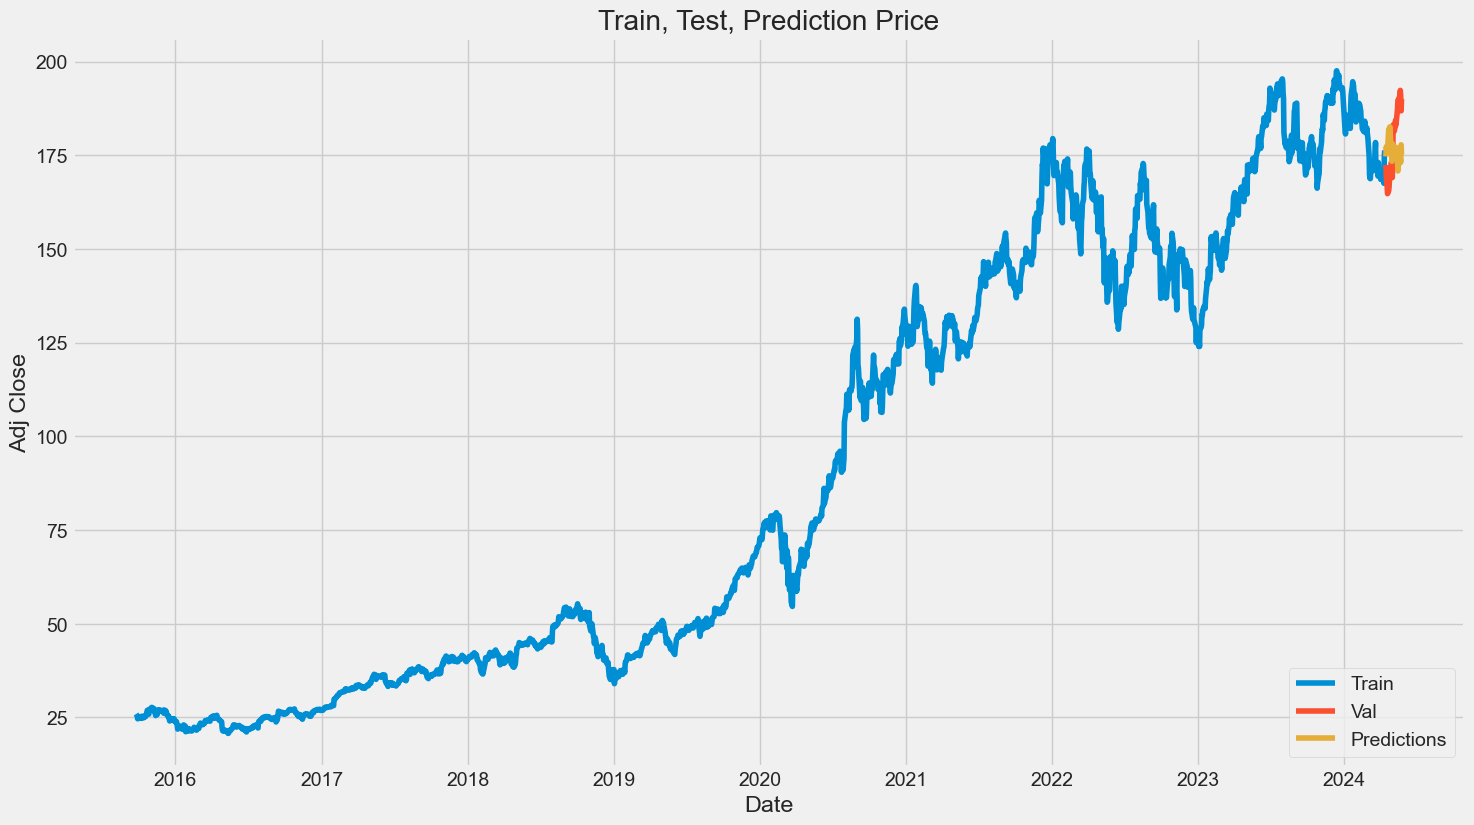

In [13]:
# vẽ đồ thị phần train, test và predict 
length = df.shape[0]
train = df[2600:length - 30]
test = df[length - 30:]
test['Predictions'] = pred_test[0]

plt.figure(figsize=(16,9))
plt.title('Train, Test, Prediction Price')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [14]:
test

,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2024-04-15,175.360001,176.630005,172.500000,172.690002,172.456085,73531800,174.721024
2024-04-16,171.750000,173.759995,168.270004,169.380005,169.150574,73711200,177.334869
2024-04-17,169.610001,170.649994,168.000000,168.000000,167.772446,50901200,176.278015
2024-04-18,168.029999,168.639999,166.550003,167.039993,166.813736,43122900,176.643082
2024-04-19,166.210007,166.399994,164.080002,165.000000,164.776505,67772100,176.173798
2024-04-22,165.520004,167.259995,164.770004,165.839996,165.615356,48116400,181.997894
2024-04-23,165.350006,167.050003,164.919998,166.899994,166.673920,49537800,180.820847
2024-04-24,166.539993,169.300003,166.210007,169.020004,168.791061,48251800,180.854446
2024-04-25,169.529999,170.610001,168.149994,169.889999,169.659882,50558300,182.626923


In [15]:
mse = np.sqrt(np.mean((test['Adj Close'] - test['Predictions']) ** 2))
print(mse)

11.828753883730588
